In [4]:
import torch
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from Custom_dataset import CustomDataset

In [2]:
adult_train = pd.read_csv('./dataset/ECG_adult_age_train.csv')
child_train = pd.read_csv('./dataset/ECG_child_age_train.csv')

In [5]:
adult_file_path = './dataset/ECG_adult_numpy_train/'
child_file_path = './dataset/ECG_child_numpy_train/'

In [4]:
adult_train['seped_AGE'] = adult_train['AGE'].apply(lambda x : int(x//10))
adult_train.loc[adult_train['seped_AGE'] >= 9,'seped_AGE'] = 8
adult_train.loc[adult_train['seped_AGE'] <= 1,'seped_AGE'] = 2
sampled_df = adult_train.groupby('seped_AGE').apply(lambda x: x.sample(n = 2000, random_state=42)).reset_index(drop=True)
sampled_df.drop('seped_AGE',axis=1,inplace=True)

In [5]:
adult_train_data, adult_valid_data = train_test_split(sampled_df,shuffle=True, random_state=42, test_size=0.1)
adult_train_data.reset_index(inplace=True,drop=True)
adult_valid_data.reset_index(inplace=True,drop=True)

In [6]:
# adult_train_data, adult_valid_data = train_test_split(adult_train,shuffle=True, random_state=42, test_size=0.1)
# adult_train_data.reset_index(inplace=True,drop=True)
# adult_valid_data.reset_index(inplace=True,drop=True)

In [7]:
adult_train_dataset = CustomDataset(adult_file_path,adult_train_data)
adult_valid_dataset = CustomDataset(adult_file_path,adult_valid_data)
child_dataset = CustomDataset(child_file_path,child_train)

In [8]:
train_adult_loader = torch.utils.data.DataLoader(adult_train_dataset, batch_size = 64, shuffle=True)
valid_adult_loader = torch.utils.data.DataLoader(adult_valid_dataset, batch_size = 64, shuffle=True)

In [15]:
import torch
import torch.nn as nn

class Temporalblock(torch.nn.Module):
    def __init__(self, N, K, MP_factor):
        super().__init__()

        self.conv_layers = torch.nn.LazyConv1d(N, K)#, padding = 'same'
        self.batchnorm_layers = torch.nn.BatchNorm1d(N)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool1d(kernel_size=MP_factor, stride=MP_factor)

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.batchnorm_layers(x)
        x = self.relu(x)
        x = self.maxpool(x)
        return x

class FCblock(torch.nn.Module):
    def __init__(self, N, dropout):
        super().__init__()
        self.linear = torch.nn.LazyLinear(N)
        self.batchnorm_layers = torch.nn.BatchNorm1d(N)
        self.relu = torch.nn.ReLU()
        self.dropout = torch.nn.Dropout(dropout)
    
    def forward(self, x):
        x = self.linear(x)
        x = self.batchnorm_layers(x)
        x = self.relu(x)
        x = self.dropout(x)
        return x

class spatial_block(torch.nn.Module):
    def __init__(self,N, K, MP_factor):
        super().__init__()
        self.conv_layers = torch.nn.LazyConv1d(N, K, )#padding='same'
        self.batchnorm_layer = torch.nn.BatchNorm1d(N)
        self.relu = torch.nn.ReLU()
        self.maxpool = torch.nn.MaxPool1d(kernel_size=MP_factor, stride=MP_factor)

    def forward(self, x):
#        x = x.transpose(1,2)
        x = self.conv_layers(x)
        x = self.batchnorm_layer(x)
        x = self.relu(x)
        x = self.maxpool(x)
        return x
    
class Custom_model(torch.nn.Module):
    def __init__(self,N, K, MP_factor):
        super().__init__()
        self.first_block = Temporalblock(16, 7, 2)
        self.temporal_block = self._make_layer(N, K, MP_factor)
        self.spatial_block = spatial_block(128, 1, 2)
        self.flatten = torch.nn.Flatten()
        self.fc1 = FCblock(128, 0.5)
        self.fc2 = FCblock(64, 0.5)

        self.linear_out = torch.nn.Linear(64,1)
    def _make_layer(self, N, K, MP_factor):
        layer = []
        for n, k, mp in zip(N, K, MP_factor):
            layer.append(Temporalblock(n, k, mp))
        return torch.nn.Sequential(*layer)
    
    def forward(self,x):
        x = self.first_block(x)
        x = self.temporal_block(x)
        x = self.spatial_block(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.linear_out(x)

        return x

N = (16,32,32,64,64,64,64)
K = (5,5,5,5,3,3,3)
MP_factor = (4,2,4,2,2,2,2)
model = Custom_model(N, K, MP_factor)
model.to('cuda')
print('model_ready')

model_ready


c:\Anaconda\envs\colon\lib\site-packages\torch\nn\modules\lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [16]:
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(params=model.parameters(),lr = 3e-4)
#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, mode='min', min_lr = 1e-5, patience=2)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer=optimizer, T_max= 20, eta_min=1e-5)

In [18]:
for epochs in range(50):
    print('train_run')
    for batch in tqdm(train_adult_loader):
        inputs = batch[0].view(-1,12,5000).to('cuda')
        label = torch.tensor(batch[2],dtype=torch.float32).to('cuda')
        output = model(torch.tensor(inputs, dtype = torch.float32))
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    valid_loss = 0
    print('valid_run')
    for batch in tqdm(valid_adult_loader):
        inputs = batch[0].view(-1,12,5000).to('cuda')
        label = torch.tensor(batch[2],dtype=torch.float32).to('cuda')
        with torch.no_grad():
            output = model(torch.tensor(inputs, dtype = torch.float32))
        loss = criterion(output, label)
        valid_loss += loss
    loss_check = valid_loss/len(valid_adult_loader)
    print(loss_check)
    scheduler.step(loss_check)

train_run


  0%|          | 0/197 [00:00<?, ?it/s]C:\Users\SNUH벤처\AppData\Local\Temp\ipykernel_3252\2992640619.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(batch[2],dtype=torch.float32).to('cuda')
C:\Users\SNUH벤처\AppData\Local\Temp\ipykernel_3252\2992640619.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  output = model(torch.tensor(inputs, dtype = torch.float32))
 27%|██▋       | 53/197 [00:02<00:06, 22.88it/s]

: 

In [12]:
valid_dataset = CustomDataset(adult_file_path,adult_train)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size = 64, shuffle=True)

pred = []
labels = []
for batch in tqdm(valid_loader):
    inputs = batch[0].view(-1,12,5000).to('cuda')
    label = torch.tensor(batch[2],dtype=torch.float32).to('cuda')
    with torch.no_grad():
        output = model(torch.tensor(inputs, dtype = torch.float32))
    pred += output.detach().cpu().tolist()
    labels += label.detach().cpu().tolist()

  0%|          | 0/546 [00:00<?, ?it/s]C:\Users\SNUH벤처\AppData\Local\Temp\ipykernel_3252\1917028487.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(batch[2],dtype=torch.float32).to('cuda')
C:\Users\SNUH벤처\AppData\Local\Temp\ipykernel_3252\1917028487.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  output = model(torch.tensor(inputs, dtype = torch.float32))
100%|██████████| 546/546 [00:27<00:00, 19.75it/s]


In [13]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(pred,labels)

60.09513312903936

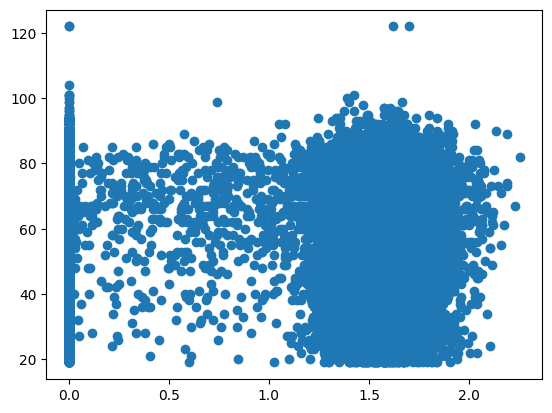

In [14]:
import matplotlib.pyplot as plt
plt.scatter(pred, labels)